# COMP S493F Lab 10

In [ ]:
%env TF_CPP_MIN_LOG_LEVEL=2
import tensorflow as tf
tf.config.experimental.enable_op_determinism()

env: TF_CPP_MIN_LOG_LEVEL=2


In this lesson, you'll work on:

- sentiment analysis, and
- using DNN, CNN, and simple RNN to process sequential data.

### Student name: *LO TSZ KIN*

# The IMDb review dataset

The IMDb movie review dataset from Internet Movie Database (IMDb, <https://www.imdb.com/>) contains movie reviews (features) and whether the reviews are positive or negative (labels).

The dataset is often used for studying *sentiment analysis*, which refers to determining whether the emotional tone of a text is positive, negative, or neural.

Let's begin by exploring the dataset. This code loads the dataset and displays its shape.

In [ ]:
from tensorflow.keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

17464789/17464789 [==============================] - 0s 0us/step
(25000,) (25000,) (25000,) (25000,)


The labels are encoded as 0 for a negative review and 1 for a positive one. The features of an example are a list of integers, which are indices of the words. The label and features of a training example are shown below.

In [ ]:
print(y_train[0], X_train[0], sep="\n")

1
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The following code creates a dictionary for mapping words to indices and another dictionary for mapping indices to words.

In [ ]:
word_to_index = imdb.get_word_index()
word_to_index = {k: v+3 for k, v in word_to_index.items()}
word_to_index["<PAD>"] = 0
word_to_index["<START>"] = 1
word_to_index["<UNKNOWN>"] = 2
index_to_word = {v: k for k, v in word_to_index.items()}

1641221/1641221 [==============================] - 0s 0us/step


Using the dictionary that maps indices to words, this code displays the text of a training example.

In [ ]:
text_0 = [index_to_word[i] for i in X_train[0]]
print(" ".join(text_0))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sho

# Utility code

This section contains some utility functions for use in the rest of the lesson.

This code contains import statements and constant definitions. The `load_and_prep_imdb()` function loads the IMDb dataset, prepares the data, and returns the data in a 4-tuple: `X_train`, `y_train`, `X_test`, `y_test`.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

NUM_WORDS = 5000    # how many most frequent words in the corpus to use
NUM_SKIP_WORDS = 0  # how many stop words to skip
WV_SIZE = 96        # word vector size, 96D, each vector having 96 values
SEQ_LEN = 100       # standardized length of text after padding/truncating

def load_and_prep_imdb():
    keras.utils.set_random_seed(42)
    (X_train, y_train), (X_test, y_test) = imdb.load_data(
        num_words=NUM_WORDS, skip_top=NUM_SKIP_WORDS)
    X_train = sequence.pad_sequences(X_train, maxlen=SEQ_LEN)
    X_test = sequence.pad_sequences(X_test, maxlen=SEQ_LEN)
    return X_train, y_train, X_test, y_test

This function retrieves the final results in a training history, i.e. values of "loss", "val_loss", "acc", and "val_acc" in the final epoch.

In [ ]:
def history_final_values(history):
    return {k: round(v[-1], 4) for k, v in history.history.items()}

This function plots a training history, including both training and validation results.

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(history.history["acc"], label="acc")
    plt.plot(history.history["val_acc"], label="val_acc")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

This function compiles and fits a model, and returns the training history.

In [ ]:
def compile_and_fit_model(model, X_train, y_train, X_test, y_test,
                          epochs=10, batch_size=256, verbose=2):
    model.compile(loss="binary_crossentropy",
                  optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=verbose,
                        validation_data=(X_test, y_test))
    return history

# Using DNN to process sequential data

Sequential data can be processed using a DNN. However, a DNN treats the sequential data as individual features and ignores the sequential nature or order information in the features.

The following DNN performs sentiment analysis on the IMDb dataset, i.e. classifying the reviews to either positive or negative.

In [ ]:
X_train, y_train, X_test, y_test = load_and_prep_imdb()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)
print(history_final_values(history))

Epoch 1/10
98/98 - 35s - loss: 0.5573 - acc: 0.6945 - val_loss: 0.3555 - val_acc: 0.8405 - 35s/epoch - 354ms/step
Epoch 2/10
98/98 - 21s - loss: 0.2595 - acc: 0.8978 - val_loss: 0.3495 - val_acc: 0.8463 - 21s/epoch - 213ms/step
Epoch 3/10
98/98 - 16s - loss: 0.1070 - acc: 0.9701 - val_loss: 0.4155 - val_acc: 0.8376 - 16s/epoch - 160ms/step
Epoch 4/10
98/98 - 13s - loss: 0.0290 - acc: 0.9965 - val_loss: 0.4808 - val_acc: 0.8373 - 13s/epoch - 136ms/step
Epoch 5/10
98/98 - 14s - loss: 0.0090 - acc: 0.9998 - val_loss: 0.5351 - val_acc: 0.8381 - 14s/epoch - 138ms/step
Epoch 6/10
98/98 - 13s - loss: 0.0042 - acc: 0.9999 - val_loss: 0.5746 - val_acc: 0.8387 - 13s/epoch - 133ms/step
Epoch 7/10
98/98 - 12s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.6053 - val_acc: 0.8392 - 12s/epoch - 123ms/step
Epoch 8/10
98/98 - 12s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.6282 - val_acc: 0.8400 - 12s/epoch - 122ms/step
Epoch 9/10
98/98 - 12s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.6504 - val_acc: 0.8393

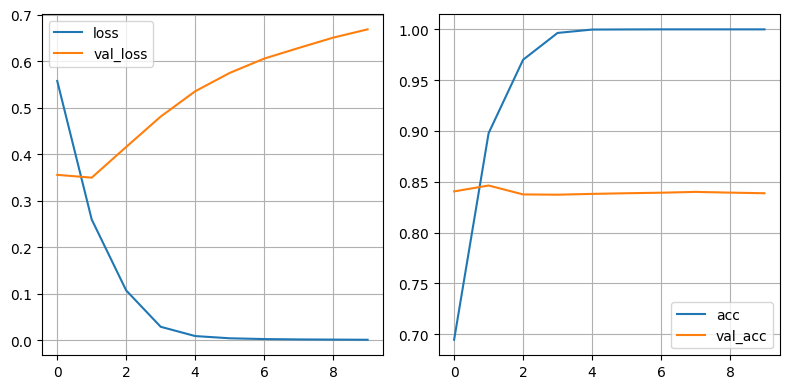

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 96)           480000    
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 64)                614464    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1094529 (4.18 MB)
Trainable params: 1094529 (4.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that the `Embedding` layer has output shape `(None, 100, 96)`. `None` refers to the "variable" or automatically-detected batch size. `100` is the sequence length, i.e. the length of text or number of words in each example. `96` is the size, or dimension, of the word vectors. The layer has 480,000 parameters, which can be explained by the expression: 480,000 = vocabulary size 5,000 &times; word vector size 96.

# Using CNN to process sequential data

A CNN with 1D convolution explores relations between successive items in sequential data.

The following code (Model-CNN#1) employs a CNN to work on the IMDb dataset. The 1D kernel size is 3. The 1D global max-pooling layer, which is often used in deep networks for language processing, reduces data size and remove a dimension in the dataset.

In [ ]:
# Model-CNN#1
X_train, y_train, X_test, y_test = load_and_prep_imdb()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation="sigmoid")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)
print(history_final_values(history))

Epoch 1/10
98/98 - 26s - loss: 0.6144 - acc: 0.7140 - val_loss: 0.4746 - val_acc: 0.7897 - 26s/epoch - 262ms/step
Epoch 2/10
98/98 - 17s - loss: 0.3907 - acc: 0.8288 - val_loss: 0.3632 - val_acc: 0.8390 - 17s/epoch - 175ms/step
Epoch 3/10
98/98 - 14s - loss: 0.2946 - acc: 0.8790 - val_loss: 0.3394 - val_acc: 0.8492 - 14s/epoch - 144ms/step
Epoch 4/10
98/98 - 12s - loss: 0.2317 - acc: 0.9107 - val_loss: 0.3358 - val_acc: 0.8513 - 12s/epoch - 126ms/step
Epoch 5/10
98/98 - 13s - loss: 0.1796 - acc: 0.9389 - val_loss: 0.3471 - val_acc: 0.8494 - 13s/epoch - 128ms/step
Epoch 6/10
98/98 - 12s - loss: 0.1357 - acc: 0.9579 - val_loss: 0.3651 - val_acc: 0.8477 - 12s/epoch - 123ms/step
Epoch 7/10
98/98 - 12s - loss: 0.0999 - acc: 0.9734 - val_loss: 0.3863 - val_acc: 0.8464 - 12s/epoch - 118ms/step
Epoch 8/10
98/98 - 12s - loss: 0.0716 - acc: 0.9846 - val_loss: 0.4149 - val_acc: 0.8438 - 12s/epoch - 118ms/step
Epoch 9/10
98/98 - 11s - loss: 0.0494 - acc: 0.9922 - val_loss: 0.4444 - val_acc: 0.8425

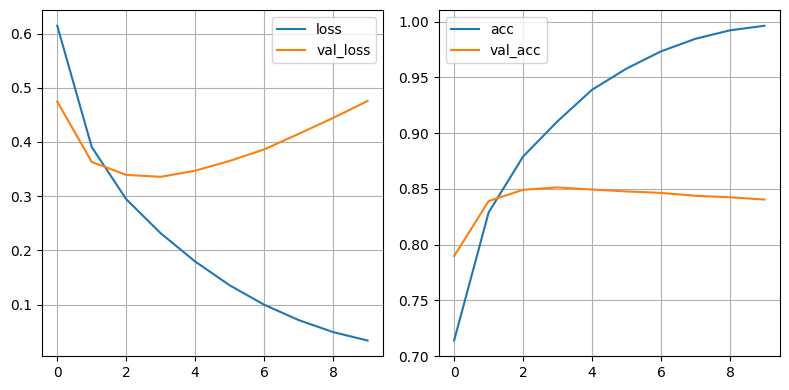

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 96)           480000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            18496     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 498561 (1.90 MB)
Trainable params: 498561 (1.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that the `Conv1D` layer has output shape `(None, 98, 64)`. `None` refers to the "variable" or automatically-detected batch size. `98` can be explained by the expression: 98 = input size 100 - kernel size 3 + 1. `64` is the number of kernels in the layer. The layer has 18,496 parameters, which can be explained by the expression: 18,496 = (kernel size 3 &times; input depth 96 + 1 bias) &times; 64 kernels.

# Practice - Question 1 of 2

The training history of Model-CNN#1 indicates overfitting. In this section, we try to mitigate overfitting and improve the model.

## Q1a

Modify the Model-CNN#1 by applying batch normalization after the convolutional layer. Plot the training history and show the model summary. This new model is called Model-CNN#2 for later reference.

In [ ]:
# Model-CNN#2

X_train, y_train, X_test, y_test = load_and_prep_imdb()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation="sigmoid")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)
print(history_final_values(history))



Epoch 1/10
98/98 - 17s - loss: 0.4594 - acc: 0.7774 - val_loss: 0.6394 - val_acc: 0.8041 - 17s/epoch - 169ms/step
Epoch 2/10
98/98 - 12s - loss: 0.2129 - acc: 0.9243 - val_loss: 0.5926 - val_acc: 0.8419 - 12s/epoch - 126ms/step
Epoch 3/10
98/98 - 14s - loss: 0.1040 - acc: 0.9773 - val_loss: 0.5187 - val_acc: 0.8349 - 14s/epoch - 146ms/step
Epoch 4/10
98/98 - 13s - loss: 0.0451 - acc: 0.9962 - val_loss: 0.4234 - val_acc: 0.8487 - 13s/epoch - 129ms/step
Epoch 5/10
98/98 - 12s - loss: 0.0193 - acc: 0.9997 - val_loss: 0.3558 - val_acc: 0.8482 - 12s/epoch - 127ms/step
Epoch 6/10
98/98 - 12s - loss: 0.0097 - acc: 1.0000 - val_loss: 0.3399 - val_acc: 0.8500 - 12s/epoch - 126ms/step
Epoch 7/10
98/98 - 15s - loss: 0.0060 - acc: 1.0000 - val_loss: 0.3688 - val_acc: 0.8503 - 15s/epoch - 154ms/step
Epoch 8/10
98/98 - 12s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.4090 - val_acc: 0.8502 - 12s/epoch - 126ms/step
Epoch 9/10
98/98 - 13s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.4401 - val_acc: 0.8493

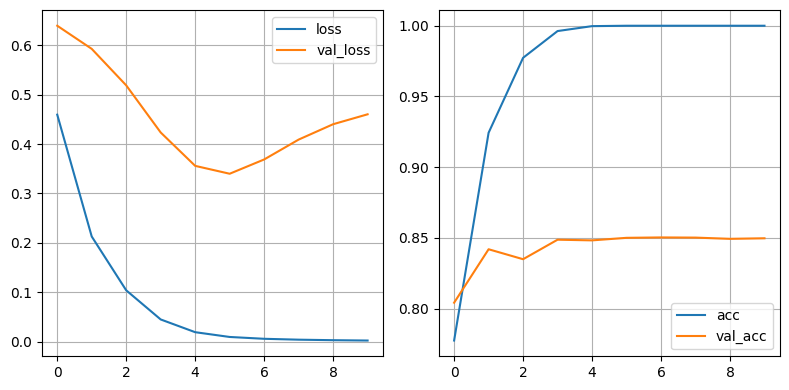

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 96)           480000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            18496     
                                                                 
 batch_normalization (Batch  (None, 98, 64)            256       
 Normalization)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 498817 (1.90 MB)
Trainable params: 498689 

## Q1b

Modify the Model-CNN#1 by applying dropout of rate 0.5 after the convolutional layer. Plot the training history and show the model summary. This new model is called Model-CNN#3 for later reference.

In [ ]:
# Model-CNN#3


X_train, y_train, X_test, y_test = load_and_prep_imdb()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.Dropout(0.5),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation="sigmoid")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)
print(history_final_values(history))




Epoch 1/10
98/98 - 31s - loss: 0.6118 - acc: 0.7003 - val_loss: 0.5220 - val_acc: 0.7830 - 31s/epoch - 314ms/step
Epoch 2/10
98/98 - 18s - loss: 0.3870 - acc: 0.8306 - val_loss: 0.4064 - val_acc: 0.8361 - 18s/epoch - 186ms/step
Epoch 3/10
98/98 - 14s - loss: 0.3032 - acc: 0.8739 - val_loss: 0.3766 - val_acc: 0.8457 - 14s/epoch - 142ms/step
Epoch 4/10
98/98 - 12s - loss: 0.2551 - acc: 0.8973 - val_loss: 0.3652 - val_acc: 0.8463 - 12s/epoch - 121ms/step
Epoch 5/10
98/98 - 12s - loss: 0.2190 - acc: 0.9157 - val_loss: 0.3573 - val_acc: 0.8462 - 12s/epoch - 123ms/step
Epoch 6/10
98/98 - 12s - loss: 0.1857 - acc: 0.9312 - val_loss: 0.3592 - val_acc: 0.8421 - 12s/epoch - 121ms/step
Epoch 7/10
98/98 - 12s - loss: 0.1574 - acc: 0.9454 - val_loss: 0.3635 - val_acc: 0.8400 - 12s/epoch - 117ms/step
Epoch 8/10
98/98 - 11s - loss: 0.1327 - acc: 0.9552 - val_loss: 0.3746 - val_acc: 0.8334 - 11s/epoch - 116ms/step
Epoch 9/10
98/98 - 12s - loss: 0.1092 - acc: 0.9639 - val_loss: 0.3856 - val_acc: 0.8303

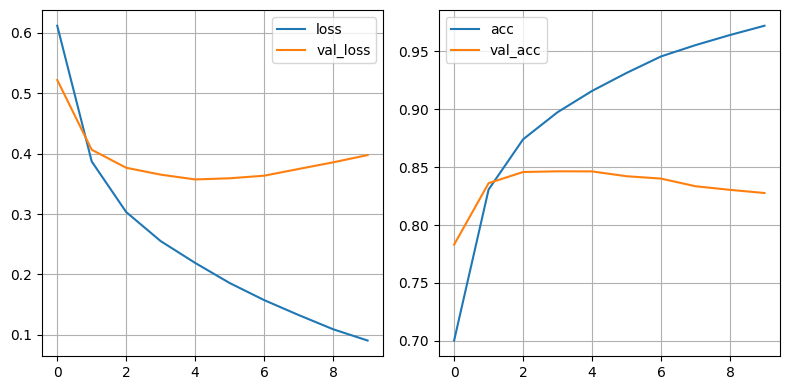

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 96)           480000    
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            18496     
                                                                 
 dropout (Dropout)           (None, 98, 64)            0         
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 498561 (1.90 MB)
Trainable params: 498561 (1.90 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

## Q1c

What are the final validation accuracy of the 3 CNN models? Which is the best model according to the validation accuracy? Write your answer in a text cell below.

Solution:


<div class='alert alert-warning' role='alert'><b>CNN model 1 have 0.8497 final validation accuracy , Model 2 have 0.851 validation accuracy , Model 3 have 0.8276 validation accuracy.

It show out that Model 2 have best validation accuracy , which mean model 2 perform well in facing unseen data</b></div>


## &#x2766;

# Using simple RNN to process sequential data

A recurrent neural network, or RNN, explores the order information in sequential data using a loop-like construct and some hidden state.

The following code (Model-RNN#1) uses a simple RNN to work on the IMDb dataset. The simple RNN layer has a simple RNN cell and 64 units, which is the length of the hidden state vector in the cell.

In [ ]:
# Model-RNN#1
X_train, y_train, X_test, y_test = load_and_prep_imdb()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.SimpleRNN(64, dropout=0.5),
    layers.Dense(1, activation="sigmoid")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)
print(history_final_values(history))

Epoch 1/10
98/98 - 37s - loss: 0.5781 - acc: 0.6673 - val_loss: 0.4240 - val_acc: 0.8081 - 37s/epoch - 378ms/step
Epoch 2/10
98/98 - 28s - loss: 0.3554 - acc: 0.8487 - val_loss: 0.3678 - val_acc: 0.8393 - 28s/epoch - 289ms/step
Epoch 3/10
98/98 - 25s - loss: 0.2983 - acc: 0.8784 - val_loss: 0.3864 - val_acc: 0.8395 - 25s/epoch - 260ms/step
Epoch 4/10
98/98 - 23s - loss: 0.2531 - acc: 0.8978 - val_loss: 0.3752 - val_acc: 0.8394 - 23s/epoch - 235ms/step
Epoch 5/10
98/98 - 24s - loss: 0.2088 - acc: 0.9181 - val_loss: 0.4223 - val_acc: 0.8368 - 24s/epoch - 241ms/step
Epoch 6/10
98/98 - 22s - loss: 0.1703 - acc: 0.9367 - val_loss: 0.4573 - val_acc: 0.8349 - 22s/epoch - 228ms/step
Epoch 7/10
98/98 - 22s - loss: 0.1372 - acc: 0.9488 - val_loss: 0.5539 - val_acc: 0.8287 - 22s/epoch - 225ms/step
Epoch 8/10
98/98 - 23s - loss: 0.1002 - acc: 0.9640 - val_loss: 0.6335 - val_acc: 0.8231 - 23s/epoch - 233ms/step
Epoch 9/10
98/98 - 23s - loss: 0.0794 - acc: 0.9719 - val_loss: 0.6271 - val_acc: 0.8264

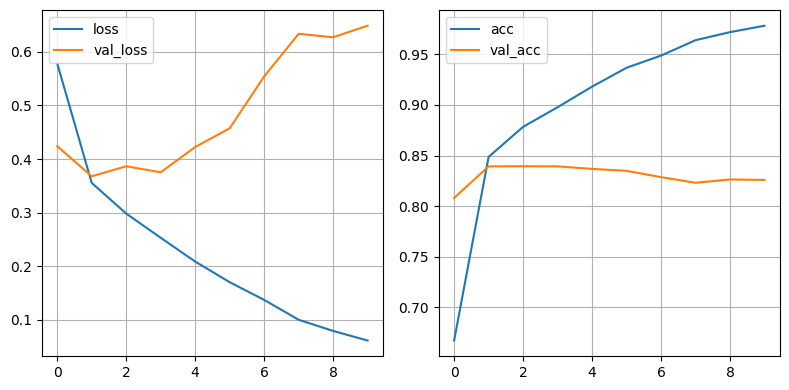

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 96)           480000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10304     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 490369 (1.87 MB)
Trainable params: 490369 (1.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that the `SimpleRNN` layer has output shape `(None, 64)`, where `64` is the number of units in the simple RNN cell. The layer has 10,304 parameters, which can be explained by the expression: 10,304 = (64 units + 96 features + 1 bias) &times; 64 units.

# Practice - Question 2 of 2

## Q2a

Modify the Model-RNN#1 by changing the simple RNN layer to use 32 units (instead of 64 units). Plot the training history and show the model summary. This new model is called Model-RNN#2 for later reference.

In [ ]:
# Model-RNN#2

X_train, y_train, X_test, y_test = load_and_prep_imdb()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.SimpleRNN(32, dropout=0.5),
    layers.Dense(1, activation="sigmoid")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)
print(history_final_values(history))


Epoch 1/10
98/98 - 41s - loss: 0.5551 - acc: 0.7092 - val_loss: 0.4505 - val_acc: 0.7960 - 41s/epoch - 422ms/step
Epoch 2/10
98/98 - 31s - loss: 0.3636 - acc: 0.8482 - val_loss: 0.3598 - val_acc: 0.8452 - 31s/epoch - 320ms/step
Epoch 3/10
98/98 - 28s - loss: 0.2976 - acc: 0.8792 - val_loss: 0.4075 - val_acc: 0.8333 - 28s/epoch - 287ms/step
Epoch 4/10
98/98 - 22s - loss: 0.2641 - acc: 0.8956 - val_loss: 0.4128 - val_acc: 0.8348 - 22s/epoch - 224ms/step
Epoch 5/10
98/98 - 23s - loss: 0.2332 - acc: 0.9106 - val_loss: 0.4060 - val_acc: 0.8389 - 23s/epoch - 231ms/step
Epoch 6/10
98/98 - 22s - loss: 0.1945 - acc: 0.9282 - val_loss: 0.3948 - val_acc: 0.8425 - 22s/epoch - 227ms/step
Epoch 7/10
98/98 - 21s - loss: 0.1634 - acc: 0.9408 - val_loss: 0.4373 - val_acc: 0.8337 - 21s/epoch - 216ms/step
Epoch 8/10
98/98 - 21s - loss: 0.1416 - acc: 0.9481 - val_loss: 0.4754 - val_acc: 0.8344 - 21s/epoch - 218ms/step
Epoch 9/10
98/98 - 21s - loss: 0.1131 - acc: 0.9601 - val_loss: 0.4996 - val_acc: 0.8329

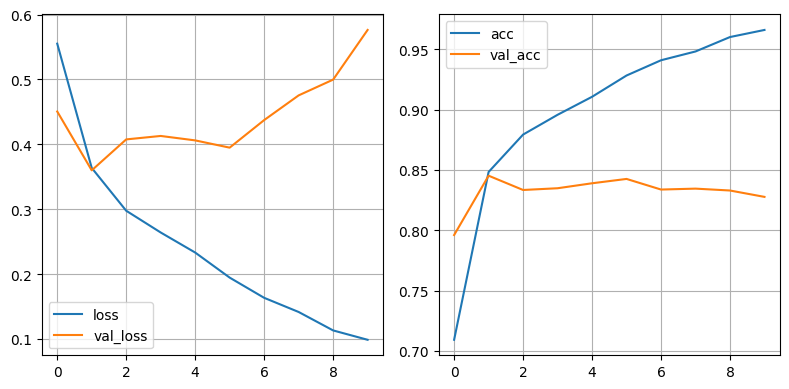

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 96)           480000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 484161 (1.85 MB)
Trainable params: 484161 (1.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Q2b

Modify the Model-RNN#1 by changing the simple RNN layer to use 16 units (instead of 64 units). Plot the training history and show the model summary. This new model is called Model-RNN#3 for later reference.

In [ ]:
# Model-RNN#3


X_train, y_train, X_test, y_test = load_and_prep_imdb()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.SimpleRNN(16, dropout=0.5),
    layers.Dense(1, activation="sigmoid")
])
history = compile_and_fit_model(model, X_train, y_train, X_test, y_test)
print(history_final_values(history))



Epoch 1/10
98/98 - 35s - loss: 0.5645 - acc: 0.7252 - val_loss: 0.4499 - val_acc: 0.8150 - 35s/epoch - 360ms/step
Epoch 2/10
98/98 - 28s - loss: 0.3871 - acc: 0.8443 - val_loss: 0.3816 - val_acc: 0.8374 - 28s/epoch - 283ms/step
Epoch 3/10
98/98 - 24s - loss: 0.3243 - acc: 0.8699 - val_loss: 0.3955 - val_acc: 0.8325 - 24s/epoch - 242ms/step
Epoch 4/10
98/98 - 23s - loss: 0.2885 - acc: 0.8858 - val_loss: 0.3830 - val_acc: 0.8383 - 23s/epoch - 235ms/step
Epoch 5/10
98/98 - 22s - loss: 0.2625 - acc: 0.8967 - val_loss: 0.3902 - val_acc: 0.8374 - 22s/epoch - 228ms/step
Epoch 6/10
98/98 - 22s - loss: 0.2434 - acc: 0.9079 - val_loss: 0.4735 - val_acc: 0.8211 - 22s/epoch - 224ms/step
Epoch 7/10
98/98 - 25s - loss: 0.2178 - acc: 0.9204 - val_loss: 0.4233 - val_acc: 0.8327 - 25s/epoch - 253ms/step
Epoch 8/10
98/98 - 22s - loss: 0.1978 - acc: 0.9280 - val_loss: 0.4242 - val_acc: 0.8329 - 22s/epoch - 229ms/step
Epoch 9/10
98/98 - 23s - loss: 0.1755 - acc: 0.9389 - val_loss: 0.4243 - val_acc: 0.8303

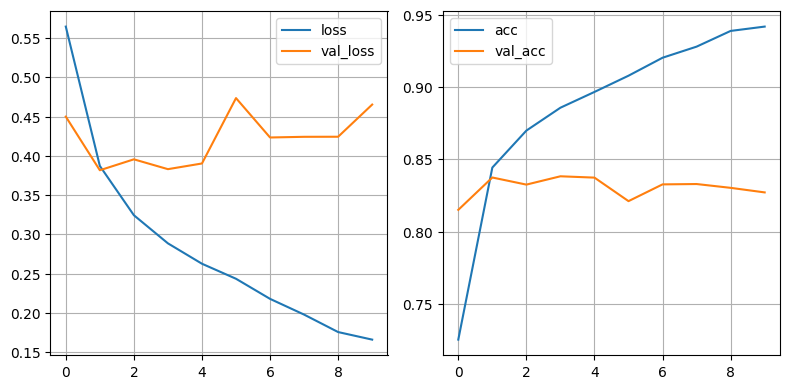

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 96)           480000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                1808      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481825 (1.84 MB)
Trainable params: 481825 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Q2c

What are the final validation accuracy of the 3 RNN models? Comment on the similarity or difference in the performance of these models. Write your answer in a text cell below.

Solution:


<div class='alert alert-warning' role='alert'><b>The RNN Model 1 have 0.826 validation accuracy , Model 2 have 0.8276 , Model 3 have 0.8271

It show the Model 2 have battter performance then other.</b></div>


## Q2d

What is the number of parameters of the simple RNN layer in Model-RNN#3? Explain the number by writing an expression for calculating it, and describing the key terms in the expression. Write your answer in a text cell below.

Solution:


<div class='alert alert-warning' role='alert'><b>The Modle 3 have Total params: 481825 , Trainable params: 481825 .

The number of units in the simple RNN layer is 16, the input dimension is 96 , output dimension is 16 ,
96*5000 = 480000 , then 16x16+96x16+16 = 1808 , then 1x1+1x16 = 17

Add together is 481825.</b></div>


## &#x2766;

# Extras

In this section, we use a simple RNN to classify newsgroup messages.

The scikit-learn library provides the 20 newsgroups text dataset, which contains about 18,000 messages in 20 newsgroups. To load the dataset, invoke the `fetch_20newsgroups()` function, as shown in the following code. This function returns a bunch object with these attributes (among others): a `data` list of text messages, a `target` array of newsgroup index, and a `target_names` list of newsgroup names. By default, `fetch_20newsgroups()` returns the training set of 11,314 messages. Calling `fetch_20newsgroups(subset="test")` returns the test set of 7,532 messages.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups()
print(type(newsgroups.data), len(newsgroups.data))
print(type(newsgroups.target), len(newsgroups.target))
display(newsgroups.target_names)

<class 'list'> 11314
<class 'numpy.ndarray'> 11314


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

The code below displays the first message with index 0.

In [ ]:
print(newsgroups.data[0].strip())

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----


This code displays the index and name the first message's newsgroup.

In [ ]:
target = newsgroups.target[0]
print(target, newsgroups.target_names[target])

7 rec.autos


## Classifying newsgroup messages

This code contains import statements and constant definitions.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

NUM_WORDS = 5000  # how many most frequent words in the corpus to use
WV_SIZE = 96      # word vector size, 96D, each vector having 96 values
SEQ_LEN = 100     # standardized length of text after padding/truncating

The following `load_and_prep_20newsgroups()` function loads and prepares the 20 newsgroups dataset. Note that the `preprocess_text()` nested function is defined as global, so it can be used both inside and outside `load_and_prep_20newsgroups()`. In this way, it can refer to the local `tokenizer` object, and can be used later for preprocessing text for making prediction in production.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

def load_and_prep_20newsgroups():
    keras.utils.set_random_seed(42)
    X, y = fetch_20newsgroups(
        remove=("headers", "footers", "quotes"), return_X_y=True)
    tokenizer = Tokenizer(NUM_WORDS)
    tokenizer.fit_on_texts(X)
    global preprocess_text
    def preprocess_text(texts):
        texts = tokenizer.texts_to_sequences(texts)
        texts = sequence.pad_sequences(texts, maxlen=SEQ_LEN)
        return texts
    X = preprocess_text(X)
    y = keras.utils.to_categorical(y, num_classes=20)
    return X, y

### E1a

Implement a simple RNN model to classify the 20 newsgroups dataset. Remember that there are 20 classes and it is a multiclass classification task.

### E1b

The following `predict_newsgroup()` function uses the model to predict the newsgroup of a text message. Invoke the function with some text messages that you write.

In [ ]:
import numpy as np

newsgroups = fetch_20newsgroups()

def predict_newsgroup(model, text):
    X = preprocess_text([text])
    y = model.predict(X, verbose=0)[0]
    y = np.argmax(y)  # reverse one-hot encoding
    y_name = newsgroups.target_names[y]
    return y, y_name

## Solutions to extra exercises

### E1a

In [ ]:
# Solution

X, y = load_and_prep_20newsgroups()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.SimpleRNN(64, dropout=0.5),
    layers.Dense(20, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["acc"])
history = model.fit(X, y, epochs=20, batch_size=256, verbose=2,
                    validation_split=0.2)
print(history_final_values(history))

Epoch 1/20
36/36 - 19s - loss: 2.9933 - acc: 0.0675 - val_loss: 2.9581 - val_acc: 0.0901 - 19s/epoch - 528ms/step
Epoch 2/20
36/36 - 13s - loss: 2.8595 - acc: 0.1581 - val_loss: 2.8783 - val_acc: 0.1308 - 13s/epoch - 370ms/step
Epoch 3/20
36/36 - 14s - loss: 2.6223 - acc: 0.2449 - val_loss: 2.6905 - val_acc: 0.1365 - 14s/epoch - 388ms/step
Epoch 4/20
36/36 - 13s - loss: 2.3359 - acc: 0.3319 - val_loss: 2.5976 - val_acc: 0.1781 - 13s/epoch - 359ms/step
Epoch 5/20
36/36 - 13s - loss: 2.0806 - acc: 0.4387 - val_loss: 2.4961 - val_acc: 0.2143 - 13s/epoch - 352ms/step
Epoch 6/20
36/36 - 13s - loss: 1.8108 - acc: 0.5447 - val_loss: 2.4586 - val_acc: 0.2316 - 13s/epoch - 351ms/step
Epoch 7/20
36/36 - 11s - loss: 1.5773 - acc: 0.6152 - val_loss: 2.4560 - val_acc: 0.2364 - 11s/epoch - 306ms/step
Epoch 8/20
36/36 - 11s - loss: 1.3684 - acc: 0.6759 - val_loss: 2.4433 - val_acc: 0.2404 - 11s/epoch - 299ms/step
Epoch 9/20
36/36 - 11s - loss: 1.2012 - acc: 0.7182 - val_loss: 2.4388 - val_acc: 0.2629

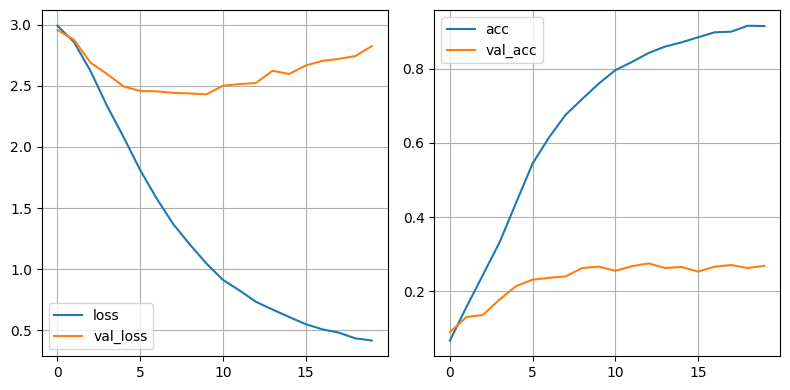

In [ ]:
plot_history(history)

### E1b

In [ ]:
for text in ["i want to buy a computer",
             "read about romantic stories",
             "watch a boring ball game"]:
    print(f"{text} -> {predict_newsgroup(model, text)}")

i want to buy a computer -> (4, 'comp.sys.mac.hardware')
read about romantic stories -> (19, 'talk.religion.misc')
watch a boring ball game -> (10, 'rec.sport.hockey')


## &#x2766;